# DH/FAccT Community Analysis: Insiders vs Outsiders

**Hypothesis**: Many review/generated papers in Digital Humanities and FAccT areas might be written by authors who are not actually part of those research communities.

We test this by:
1. Identifying DH/FAccT papers using keyword matching (from existing analysis)
2. Looking up author publishing histories via OpenAlex topics
3. Comparing whether review paper authors have prior publications in relevant topics vs. regular paper authors

In [1]:
import json
import re
from pathlib import Path
from collections import Counter, defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')

DATA_DIR = Path('../data')
OPENALEX_DIR = DATA_DIR / 'openalex'

## 1. Define Keywords for Paper Classification

In [2]:
# Digital Humanities keywords
DH_KEYWORDS = [
    'digital humanities', 'computational humanities', 'cultural analytics',
    'distant reading', 'literary', 'literature', 'poetry', 'fiction',
    'narrative', 'storytelling', 'authorship', 'stylometry', 'text reuse',
    'historical', 'history', 'archive', 'manuscript', 'ancient', 'medieval',
    'classical', 'heritage', 'digitization', 'cultural', 'culture', 'art',
    'music', 'film', 'media studies'
]

# FAccT keywords
FACCT_KEYWORDS = [
    'fairness', 'accountability', 'transparency', 'explainability',
    'interpretability', 'bias', 'discrimination', 'harm', 'toxicity',
    'hate speech', 'misinformation', 'ethics', 'ethical', 'moral',
    'responsible ai', 'ai safety', 'value alignment', 'social impact',
    'societal', 'equity', 'justice', 'marginalized', 'underrepresented',
    'gender bias', 'racial bias', 'stereotype', 'governance', 'regulation',
    'audit', 'privacy', 'surveillance', 'consent'
]

# Core NLP keywords (baseline comparison)
CORE_NLP_KEYWORDS = [
    'named entity recognition', 'part-of-speech', 'dependency parsing',
    'semantic parsing', 'coreference', 'relation extraction',
    'text classification', 'sentiment analysis', 'machine translation',
    'question answering', 'summarization', 'text generation', 'dialogue',
    'language model', 'transformer', 'bert', 'gpt', 'encoder-decoder',
    'seq2seq', 'fine-tuning', 'pre-training', 'prompt', 'word embedding'
]

def classify_abstract(abstract: str) -> dict:
    """Classify paper based on abstract keywords."""
    if not abstract:
        return {'dh': False, 'facct': False, 'core_nlp': False}
    
    abstract_lower = abstract.lower()
    return {
        'dh': any(kw in abstract_lower for kw in DH_KEYWORDS),
        'facct': any(kw in abstract_lower for kw in FACCT_KEYWORDS),
        'core_nlp': any(kw in abstract_lower for kw in CORE_NLP_KEYWORDS)
    }

## 2. Load Data

In [3]:
# Load OpenAlex enriched works
print("Loading OpenAlex works...")
with open(OPENALEX_DIR / 'works_enriched.json') as f:
    works = json.load(f)
print(f"  Loaded {len(works):,} works")

# Load author profiles
print("Loading author profiles...")
author_profiles = {}
with open(OPENALEX_DIR / 'author_profiles.jsonl') as f:
    for line in f:
        profile = json.loads(line.strip())
        author_profiles[profile['author_id']] = profile
print(f"  Loaded {len(author_profiles):,} author profiles")

# Load original paper metadata (for abstracts)
print("Loading paper metadata for abstracts...")
abstracts = {}
categories = ['cs-AI', 'cs-CL', 'cs-CR', 'cs-CV', 'cs-CY', 'cs-HC', 'cs-IR', 'cs-LG', 'cs-RO', 'cs-SE']
for cat in categories:
    metadata_file = DATA_DIR / 'processed' / cat / 'paper_metadata.json'
    if metadata_file.exists():
        with open(metadata_file) as f:
            for paper in json.load(f):
                arxiv_id = str(paper.get('arxiv_id', ''))
                abstracts[arxiv_id] = paper.get('abstract', '')
print(f"  Loaded {len(abstracts):,} abstracts")

Loading OpenAlex works...
  Loaded 102,447 works
Loading author profiles...
  Loaded 244,345 author profiles
Loading paper metadata for abstracts...
  Loaded 138,244 abstracts


## 3. Classify Papers and Build Analysis DataFrame

In [4]:
# Build paper records with community classification
paper_records = []

for arxiv_id, work in works.items():
    abstract = abstracts.get(arxiv_id, '')
    classification = classify_abstract(abstract)
    
    # Get primary topic from OpenAlex
    primary_topic = work.get('primary_topic') or {}
    topics = work.get('topics', [])
    
    paper_records.append({
        'arxiv_id': arxiv_id,
        'paper_type': work.get('paper_type', 'unknown'),
        'category': work.get('category', ''),
        'is_dh': classification['dh'],
        'is_facct': classification['facct'],
        'is_core_nlp': classification['core_nlp'],
        'primary_topic': primary_topic.get('name', ''),
        'primary_subfield': primary_topic.get('subfield', ''),
        'all_topics': [t.get('name', '') for t in topics],
        'all_subfields': list(set(t.get('subfield', '') for t in topics if t.get('subfield'))),
        'num_authors': len(work.get('authorships', []))
    })

papers_df = pd.DataFrame(paper_records)
print(f"Papers: {len(papers_df):,}")
print(f"\nCommunity breakdown:")
print(f"  DH papers: {papers_df['is_dh'].sum():,}")
print(f"  FAccT papers: {papers_df['is_facct'].sum():,}")
print(f"  Core NLP papers: {papers_df['is_core_nlp'].sum():,}")

Papers: 102,447

Community breakdown:
  DH papers: 56,313
  FAccT papers: 17,260
  Core NLP papers: 32,271


In [5]:
# Review rates by community
print("Review Paper Rates by Community:")
print("=" * 50)

for community, col in [('Digital Humanities', 'is_dh'), ('FAccT', 'is_facct'), ('Core NLP', 'is_core_nlp')]:
    subset = papers_df[papers_df[col]]
    if len(subset) > 0:
        review_rate = (subset['paper_type'] == 'review').mean() * 100
        print(f"{community}: {review_rate:.1f}% review papers (n={len(subset):,})")

# Overall baseline
overall_review_rate = (papers_df['paper_type'] == 'review').mean() * 100
print(f"\nOverall: {overall_review_rate:.1f}% review papers (n={len(papers_df):,})")

Review Paper Rates by Community:
Digital Humanities: 4.2% review papers (n=56,313)
FAccT: 8.0% review papers (n=17,260)
Core NLP: 2.6% review papers (n=32,271)

Overall: 3.5% review papers (n=102,447)


## 4. Define "Community Insider" Based on Author Topics

An author is considered a "community insider" if their OpenAlex profile shows they've published in relevant topics before.

In [6]:
# OpenAlex topics/subfields that map to DH
DH_OPENALEX_SUBFIELDS = {
    'Literature and Literary Theory',
    'History',
    'Linguistics and Language',
    'Visual Arts and Performing Arts',
    'Music',
    'Philosophy',
    'Cultural Studies',
    'Archeology',
    'Classics',
    'Library and Information Sciences',
}

# OpenAlex topics/subfields that map to FAccT
FACCT_OPENALEX_SUBFIELDS = {
    'Law',
    'Sociology and Political Science',
    'Philosophy',  # ethics
    'Social Psychology',
    'Communication',
    'Health Policy',
}

# Also look for specific topics in author's work history
DH_TOPIC_KEYWORDS = ['humanities', 'literary', 'cultural', 'historical', 'archive', 'museum', 'heritage']
FACCT_TOPIC_KEYWORDS = ['fairness', 'bias', 'ethics', 'privacy', 'transparency', 'accountability', 'discrimination']

def check_author_community(profile: dict, community: str) -> dict:
    """
    Check if author has published in community-related topics.
    Returns dict with insider indicators.
    """
    if not profile or profile.get('not_found'):
        return {'is_insider': None, 'relevant_institution': False}
    
    # Check last known institutions for relevant departments
    institutions = profile.get('last_known_institutions', []) or []
    inst_names = ' '.join(i.get('name', '').lower() for i in institutions)
    
    if community == 'dh':
        subfields = DH_OPENALEX_SUBFIELDS
        topic_keywords = DH_TOPIC_KEYWORDS
        # Check for humanities-related institutions
        relevant_inst = any(kw in inst_names for kw in ['humanities', 'arts', 'library', 'history', 'literature'])
    elif community == 'facct':
        subfields = FACCT_OPENALEX_SUBFIELDS
        topic_keywords = FACCT_TOPIC_KEYWORDS
        # Check for law/policy/ethics institutions
        relevant_inst = any(kw in inst_names for kw in ['law', 'policy', 'ethics', 'social'])
    else:
        return {'is_insider': None, 'relevant_institution': False}
    
    # For now, we don't have full topic history in the profile
    # We'll use a proxy: check if they have low CS publication ratio
    # or relevant institution affiliation
    
    return {
        'is_insider': None,  # We'll compute this differently
        'relevant_institution': relevant_inst,
        'h_index': profile.get('h_index', 0),
        'works_count': profile.get('works_count', 0)
    }

## 5. Analyze Author Backgrounds for DH/FAccT Papers

Since we have OpenAlex topics for each paper, we can check what topics the paper itself is tagged with, and compare review vs regular papers.

In [7]:
# Build author-paper records for DH/FAccT papers
author_paper_records = []

for arxiv_id, work in works.items():
    abstract = abstracts.get(arxiv_id, '')
    classification = classify_abstract(abstract)
    
    # Only include DH or FAccT papers
    if not (classification['dh'] or classification['facct']):
        continue
    
    paper_type = work.get('paper_type', 'unknown')
    topics = work.get('topics', [])
    subfields = set(t.get('subfield', '') for t in topics if t.get('subfield'))
    
    for authorship in work.get('authorships', []):
        author_id = authorship.get('author_id', '')
        if not author_id:
            continue
        
        profile = author_profiles.get(author_id, {})
        
        author_paper_records.append({
            'arxiv_id': arxiv_id,
            'author_id': author_id,
            'paper_type': paper_type,
            'is_dh': classification['dh'],
            'is_facct': classification['facct'],
            'position': authorship.get('position', ''),
            # Author metrics
            'h_index': profile.get('h_index', 0),
            'works_count': profile.get('works_count', 0),
            'cited_by_count': profile.get('cited_by_count', 0),
            # Paper's OpenAlex subfields
            'paper_subfields': list(subfields),
            'has_humanities_subfield': bool(subfields & DH_OPENALEX_SUBFIELDS),
            'has_social_subfield': bool(subfields & FACCT_OPENALEX_SUBFIELDS),
        })

dh_facct_authors_df = pd.DataFrame(author_paper_records)
print(f"DH/FAccT author-paper instances: {len(dh_facct_authors_df):,}")

DH/FAccT author-paper instances: 292,781


In [8]:
# Analyze: Do review papers in DH/FAccT have different OpenAlex topic profiles?
print("=" * 60)
print("PAPER TOPIC ANALYSIS: Review vs Regular in DH/FAccT")
print("=" * 60)

# DH papers
dh_papers = dh_facct_authors_df[dh_facct_authors_df['is_dh']].drop_duplicates('arxiv_id')
dh_review = dh_papers[dh_papers['paper_type'] == 'review']
dh_regular = dh_papers[dh_papers['paper_type'] == 'regular']

print(f"\nDigital Humanities Papers:")
print(f"  Review: {len(dh_review):,} papers")
print(f"  Regular: {len(dh_regular):,} papers")
if len(dh_review) > 0 and len(dh_regular) > 0:
    print(f"  Review papers with humanities subfield: {dh_review['has_humanities_subfield'].mean()*100:.1f}%")
    print(f"  Regular papers with humanities subfield: {dh_regular['has_humanities_subfield'].mean()*100:.1f}%")

# FAccT papers  
facct_papers = dh_facct_authors_df[dh_facct_authors_df['is_facct']].drop_duplicates('arxiv_id')
facct_review = facct_papers[facct_papers['paper_type'] == 'review']
facct_regular = facct_papers[facct_papers['paper_type'] == 'regular']

print(f"\nFAccT Papers:")
print(f"  Review: {len(facct_review):,} papers")
print(f"  Regular: {len(facct_regular):,} papers")
if len(facct_review) > 0 and len(facct_regular) > 0:
    print(f"  Review papers with social science subfield: {facct_review['has_social_subfield'].mean()*100:.1f}%")
    print(f"  Regular papers with social science subfield: {facct_regular['has_social_subfield'].mean()*100:.1f}%")

PAPER TOPIC ANALYSIS: Review vs Regular in DH/FAccT

Digital Humanities Papers:
  Review: 2,351 papers
  Regular: 11,284 papers
  Review papers with humanities subfield: 1.4%
  Regular papers with humanities subfield: 0.9%

FAccT Papers:
  Review: 1,355 papers
  Regular: 3,902 papers
  Review papers with social science subfield: 17.7%
  Regular papers with social science subfield: 10.2%


## 6. Author Career Analysis: Are Review Paper Authors Less Established?

In [9]:
# Compare author metrics for DH papers
print("=" * 60)
print("AUTHOR CAREER ANALYSIS: DH Papers")
print("=" * 60)

dh_authors = dh_facct_authors_df[dh_facct_authors_df['is_dh']]
dh_review_authors = dh_authors[dh_authors['paper_type'] == 'review']
dh_regular_authors = dh_authors[dh_authors['paper_type'] == 'regular']

for metric in ['h_index', 'works_count', 'cited_by_count']:
    review_vals = dh_review_authors[metric].dropna()
    regular_vals = dh_regular_authors[metric].dropna()
    
    if len(review_vals) > 0 and len(regular_vals) > 0:
        stat, p_value = stats.mannwhitneyu(review_vals, regular_vals, alternative='two-sided')
        print(f"\n{metric}:")
        print(f"  Review authors:  median={review_vals.median():.0f}, mean={review_vals.mean():.0f}")
        print(f"  Regular authors: median={regular_vals.median():.0f}, mean={regular_vals.mean():.0f}")
        print(f"  Mann-Whitney p-value: {p_value:.2e}")

AUTHOR CAREER ANALYSIS: DH Papers

h_index:
  Review authors:  median=10, mean=16
  Regular authors: median=10, mean=17
  Mann-Whitney p-value: 1.15e-01

works_count:
  Review authors:  median=46, mean=126
  Regular authors: median=48, mean=133
  Mann-Whitney p-value: 5.76e-02

cited_by_count:
  Review authors:  median=452, mean=3172
  Regular authors: median=462, mean=3333
  Mann-Whitney p-value: 1.67e-01


In [10]:
# Compare author metrics for FAccT papers
print("=" * 60)
print("AUTHOR CAREER ANALYSIS: FAccT Papers")
print("=" * 60)

facct_authors = dh_facct_authors_df[dh_facct_authors_df['is_facct']]
facct_review_authors = facct_authors[facct_authors['paper_type'] == 'review']
facct_regular_authors = facct_authors[facct_authors['paper_type'] == 'regular']

for metric in ['h_index', 'works_count', 'cited_by_count']:
    review_vals = facct_review_authors[metric].dropna()
    regular_vals = facct_regular_authors[metric].dropna()
    
    if len(review_vals) > 0 and len(regular_vals) > 0:
        stat, p_value = stats.mannwhitneyu(review_vals, regular_vals, alternative='two-sided')
        print(f"\n{metric}:")
        print(f"  Review authors:  median={review_vals.median():.0f}, mean={review_vals.mean():.0f}")
        print(f"  Regular authors: median={regular_vals.median():.0f}, mean={regular_vals.mean():.0f}")
        print(f"  Mann-Whitney p-value: {p_value:.2e}")

AUTHOR CAREER ANALYSIS: FAccT Papers

h_index:
  Review authors:  median=9, mean=16
  Regular authors: median=10, mean=17
  Mann-Whitney p-value: 2.25e-01

works_count:
  Review authors:  median=42, mean=121
  Regular authors: median=46, mean=130
  Mann-Whitney p-value: 1.19e-02

cited_by_count:
  Review authors:  median=415, mean=3699
  Regular authors: median=444, mean=3298
  Mann-Whitney p-value: 5.14e-01


## 7. Topic Distribution: What Fields Are Authors Coming From?

In [11]:
# Collect all subfields for review vs regular papers in DH/FAccT
def get_subfield_distribution(df, paper_type):
    """Get distribution of OpenAlex subfields for papers of a given type."""
    subset = df[df['paper_type'] == paper_type]
    all_subfields = []
    for subfields in subset['paper_subfields']:
        all_subfields.extend(subfields)
    return Counter(all_subfields)

# DH papers
dh_unique = dh_facct_authors_df[dh_facct_authors_df['is_dh']].drop_duplicates('arxiv_id')
dh_review_subfields = get_subfield_distribution(dh_unique, 'review')
dh_regular_subfields = get_subfield_distribution(dh_unique, 'regular')

print("=" * 60)
print("SUBFIELD DISTRIBUTION: DH Papers")
print("=" * 60)
print("\nTop subfields in REVIEW papers:")
for sf, count in dh_review_subfields.most_common(10):
    print(f"  {sf}: {count}")
print("\nTop subfields in REGULAR papers:")
for sf, count in dh_regular_subfields.most_common(10):
    print(f"  {sf}: {count}")

SUBFIELD DISTRIBUTION: DH Papers

Top subfields in REVIEW papers:
  Artificial Intelligence: 715
  Information Systems: 460
  Safety Research: 201
  Sociology and Political Science: 187
  Computer Networks and Communications: 177
  Computer Vision and Pattern Recognition: 156
  Management Information Systems: 117
  Health Informatics: 111
  Computer Science Applications: 109
  Management Science and Operations Research: 99

Top subfields in REGULAR papers:
  Artificial Intelligence: 4289
  Computer Vision and Pattern Recognition: 2201
  Information Systems: 1726
  Computer Networks and Communications: 795
  Control and Systems Engineering: 625
  Signal Processing: 602
  Electrical and Electronic Engineering: 393
  Management Science and Operations Research: 381
  Aerospace Engineering: 365
  Sociology and Political Science: 364


In [12]:
# FAccT papers
facct_unique = dh_facct_authors_df[dh_facct_authors_df['is_facct']].drop_duplicates('arxiv_id')
facct_review_subfields = get_subfield_distribution(facct_unique, 'review')
facct_regular_subfields = get_subfield_distribution(facct_unique, 'regular')

print("=" * 60)
print("SUBFIELD DISTRIBUTION: FAccT Papers")
print("=" * 60)
print("\nTop subfields in REVIEW papers:")
for sf, count in facct_review_subfields.most_common(10):
    print(f"  {sf}: {count}")
print("\nTop subfields in REGULAR papers:")
for sf, count in facct_regular_subfields.most_common(10):
    print(f"  {sf}: {count}")

SUBFIELD DISTRIBUTION: FAccT Papers

Top subfields in REVIEW papers:
  Artificial Intelligence: 413
  Information Systems: 219
  Safety Research: 193
  Sociology and Political Science: 181
  Health Informatics: 84
  Computer Networks and Communications: 65
  Computer Science Applications: 62
  Management Information Systems: 61
  Management Science and Operations Research: 52
  Computer Vision and Pattern Recognition: 49

Top subfields in REGULAR papers:
  Artificial Intelligence: 1712
  Information Systems: 631
  Computer Vision and Pattern Recognition: 455
  Sociology and Political Science: 273
  Computer Networks and Communications: 248
  Signal Processing: 178
  Management Science and Operations Research: 138
  Safety Research: 134
  Electrical and Electronic Engineering: 128
  Control and Systems Engineering: 109


## 8. Visualizations

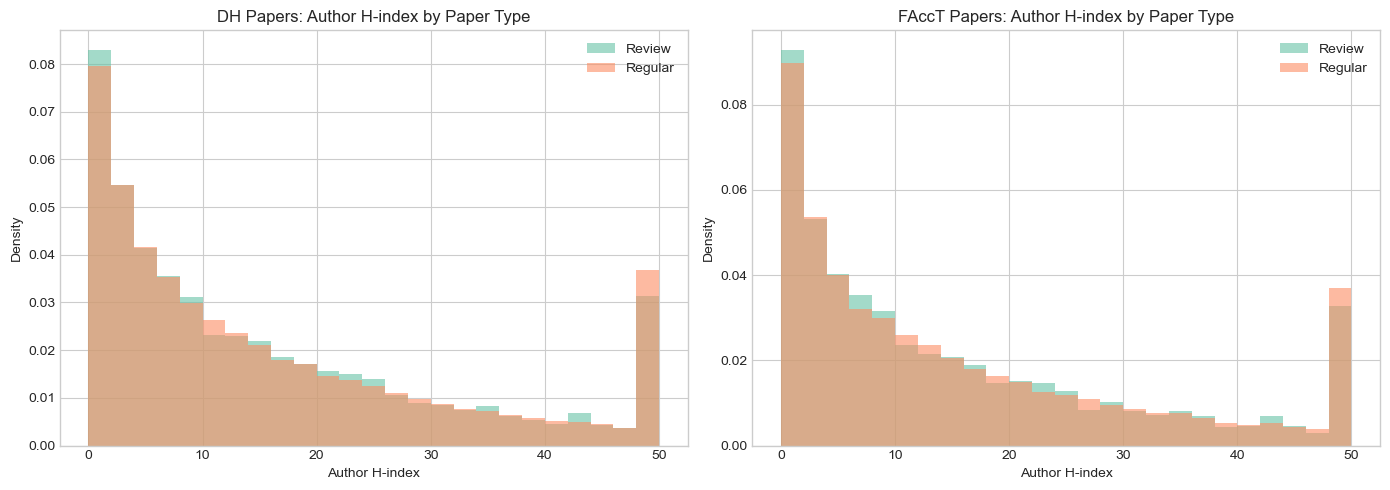

In [13]:
# Compare h-index distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# DH
ax1 = axes[0]
ax1.hist(dh_review_authors['h_index'].clip(upper=50), bins=25, alpha=0.6, label='Review', density=True)
ax1.hist(dh_regular_authors['h_index'].clip(upper=50), bins=25, alpha=0.6, label='Regular', density=True)
ax1.set_xlabel('Author H-index')
ax1.set_ylabel('Density')
ax1.set_title('DH Papers: Author H-index by Paper Type')
ax1.legend()

# FAccT
ax2 = axes[1]
ax2.hist(facct_review_authors['h_index'].clip(upper=50), bins=25, alpha=0.6, label='Review', density=True)
ax2.hist(facct_regular_authors['h_index'].clip(upper=50), bins=25, alpha=0.6, label='Regular', density=True)
ax2.set_xlabel('Author H-index')
ax2.set_ylabel('Density')
ax2.set_title('FAccT Papers: Author H-index by Paper Type')
ax2.legend()

plt.tight_layout()
plt.show()

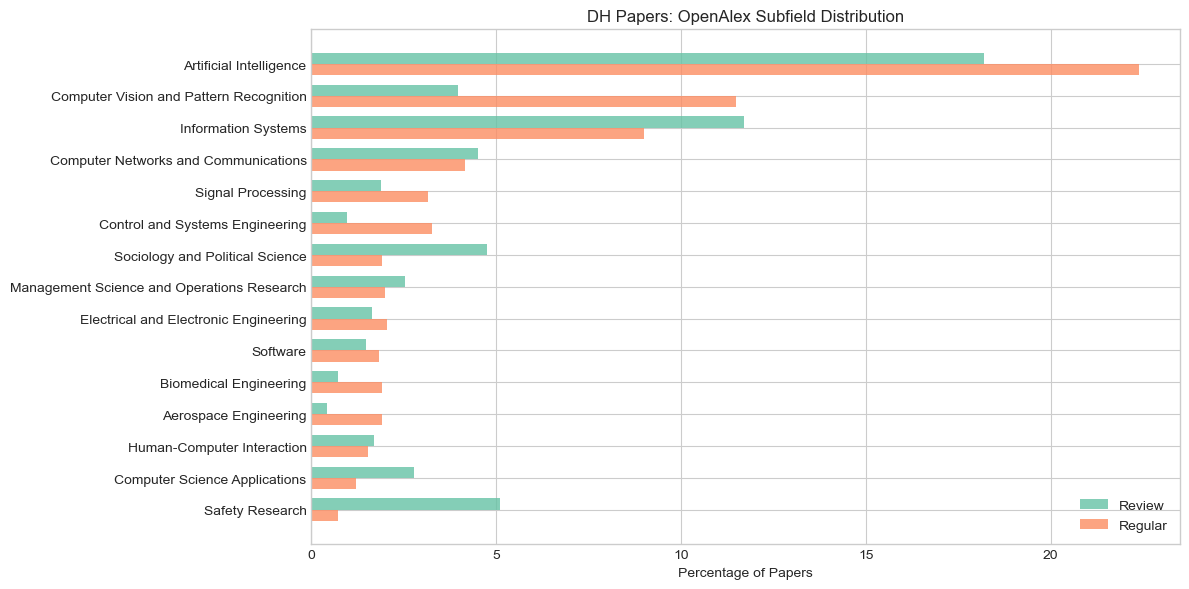

In [14]:
# Subfield comparison chart
def plot_subfield_comparison(review_counts, regular_counts, title):
    """Plot comparison of subfield distributions."""
    # Get all subfields
    all_sfs = set(review_counts.keys()) | set(regular_counts.keys())
    # Sort by total count
    sf_totals = {sf: review_counts.get(sf, 0) + regular_counts.get(sf, 0) for sf in all_sfs}
    top_sfs = sorted(sf_totals.keys(), key=lambda x: sf_totals[x], reverse=True)[:15]
    
    # Normalize to percentages
    review_total = sum(review_counts.values())
    regular_total = sum(regular_counts.values())
    
    review_pcts = [100 * review_counts.get(sf, 0) / review_total if review_total > 0 else 0 for sf in top_sfs]
    regular_pcts = [100 * regular_counts.get(sf, 0) / regular_total if regular_total > 0 else 0 for sf in top_sfs]
    
    x = np.arange(len(top_sfs))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.barh(x - width/2, review_pcts, width, label='Review', alpha=0.8)
    ax.barh(x + width/2, regular_pcts, width, label='Regular', alpha=0.8)
    
    ax.set_yticks(x)
    ax.set_yticklabels(top_sfs)
    ax.set_xlabel('Percentage of Papers')
    ax.set_title(title)
    ax.legend()
    ax.invert_yaxis()
    
    plt.tight_layout()
    plt.show()

plot_subfield_comparison(dh_review_subfields, dh_regular_subfields, 
                         'DH Papers: OpenAlex Subfield Distribution')

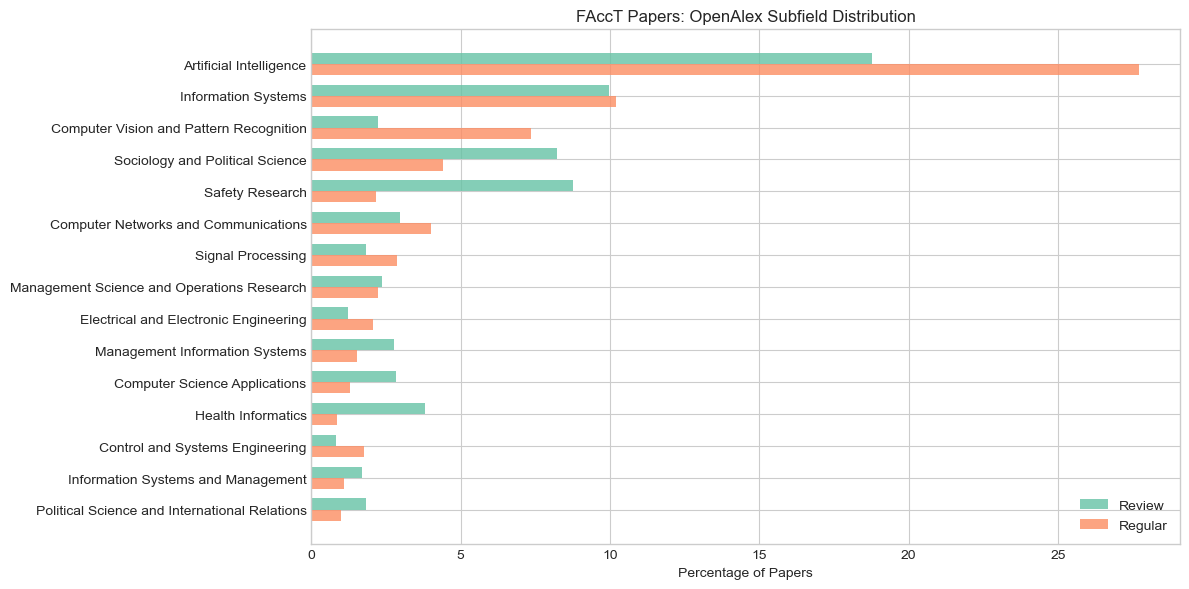

In [15]:
plot_subfield_comparison(facct_review_subfields, facct_regular_subfields,
                         'FAccT Papers: OpenAlex Subfield Distribution')

## 9. Summary

In [16]:
print("=" * 60)
print("SUMMARY: Are DH/FAccT Review Papers Written by Outsiders?")
print("=" * 60)

print("\nDigital Humanities:")
print(f"  Total DH papers: {len(dh_unique):,}")
print(f"  Review papers: {len(dh_review):,} ({100*len(dh_review)/len(dh_unique):.1f}%)")
if len(dh_review_authors) > 0 and len(dh_regular_authors) > 0:
    print(f"  Review author median h-index: {dh_review_authors['h_index'].median():.0f}")
    print(f"  Regular author median h-index: {dh_regular_authors['h_index'].median():.0f}")

print("\nFAccT:")
print(f"  Total FAccT papers: {len(facct_unique):,}")
print(f"  Review papers: {len(facct_review):,} ({100*len(facct_review)/len(facct_unique):.1f}%)")
if len(facct_review_authors) > 0 and len(facct_regular_authors) > 0:
    print(f"  Review author median h-index: {facct_review_authors['h_index'].median():.0f}")
    print(f"  Regular author median h-index: {facct_regular_authors['h_index'].median():.0f}")

print("\nKey Observations:")
print("  - Compare subfield distributions to see if review papers come from different fields")
print("  - Lower h-index for review authors may indicate less established researchers")
print("  - Check if review papers have fewer humanities/social science subfield tags")

SUMMARY: Are DH/FAccT Review Papers Written by Outsiders?

Digital Humanities:
  Total DH papers: 55,929
  Review papers: 2,351 (4.2%)
  Review author median h-index: 10
  Regular author median h-index: 10

FAccT:
  Total FAccT papers: 17,096
  Review papers: 1,355 (7.9%)
  Review author median h-index: 9
  Regular author median h-index: 10

Key Observations:
  - Compare subfield distributions to see if review papers come from different fields
  - Lower h-index for review authors may indicate less established researchers
  - Check if review papers have fewer humanities/social science subfield tags
